In [1]:
import pandas as pd
from datetime import datetime, date, time, timedelta
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import mlflow
import sys
import os
import numpy as np
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from prophet import Prophet
from functions_anton.functions_models import step_modification_to_forecast 
#from functions_anton.functions_models import plot_forecast 

# Adjusted plotting function

In [2]:
def plot_forecast(df_train, df_test, station_uuid = None, df_train_prediction=None, df_test_prediction=None, train_dates=None, test_dates=None, train_dates_plot=None, test_dates_plot=None):
    plt.figure(figsize=(15, 6))
    
    train_mask = (df_train['date'] >= train_dates[0]) & (df_train['date'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['date'] >= test_dates[0]) & (df_test['date'] <= test_dates[1]) if test_dates else slice(None)


    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['date'] >= train_dates[0]) & (df_train_prediction['date'] <= train_dates[1])]
        #plt.plot(df_train_prediction['date'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['date'] >= test_dates[0]) & (df_test_prediction['date'] <= test_dates[1])]
        plt.plot(df_test_prediction['date'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='date', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('date').reset_index(drop=True)

        mae_dict = {}
        rmse_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['date'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['date'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                rmse = np.sqrt(mean_squared_error(df_subset['e5_actual'], df_subset['e5_pred']))
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                rmse_dict[days] = rmse
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day RMSE in cent: {rmse *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                #plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         #transform=plt.gca().transAxes, fontsize=12, 
                         #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))
    
    plt.plot(df_train.loc[train_mask, 'date'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.plot(df_test.loc[test_mask, 'date'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)

    plt.legend(fontsize=12, title_fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('E5 Price: Actual vs Prediction', fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('E5 price', fontsize=14)
    plt.tight_layout(pad=2)
    plt.gca().set_facecolor('#f7f7fa')
    plt.gcf().patch.set_facecolor('#eaeaf2')
    plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
    plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
    plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
    plt.savefig("prediction.png")
    mlflow.log_artifact("prediction.png")
    plt.show()

    # After the loop, you have:
    mae_1_day = mae_dict.get(1)
    mae_3_day = mae_dict.get(3)
    mae_7_day = mae_dict.get(7)
    rmse_1_day = rmse_dict.get(1)
    rmse_3_day = rmse_dict.get(3)
    rmse_7_day = rmse_dict.get(7)
    r2_1_day = r2_dict.get(1)
    r2_3_day = r2_dict.get(3)
    r2_7_day = r2_dict.get(7)

    return mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day





    

# MLFlow

In [3]:
# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"FuelProphet_Anton_prophet_Loop_{timestamp}"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")


Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


# Data

In [4]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

In [5]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}

# Training


Processing dataset: df01


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/a38kf4w9.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/2pfdh_4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40358', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/a38kf4w9.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/2pfdh_4v.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model8v2lctzc/prophet_model-20250619190553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.3254
1-Day RMSE in cent: 1.8215
1-Day r2-score: 0.3746
3-Day MAE in cent: 1.9956
3-Day RMSE in cent: 2.7107
3-Day r2-score: -0.4518
7-Day MAE in cent: 2.6048
7-Day RMSE in cent: 3.4834
7-Day r2-score: -0.9165


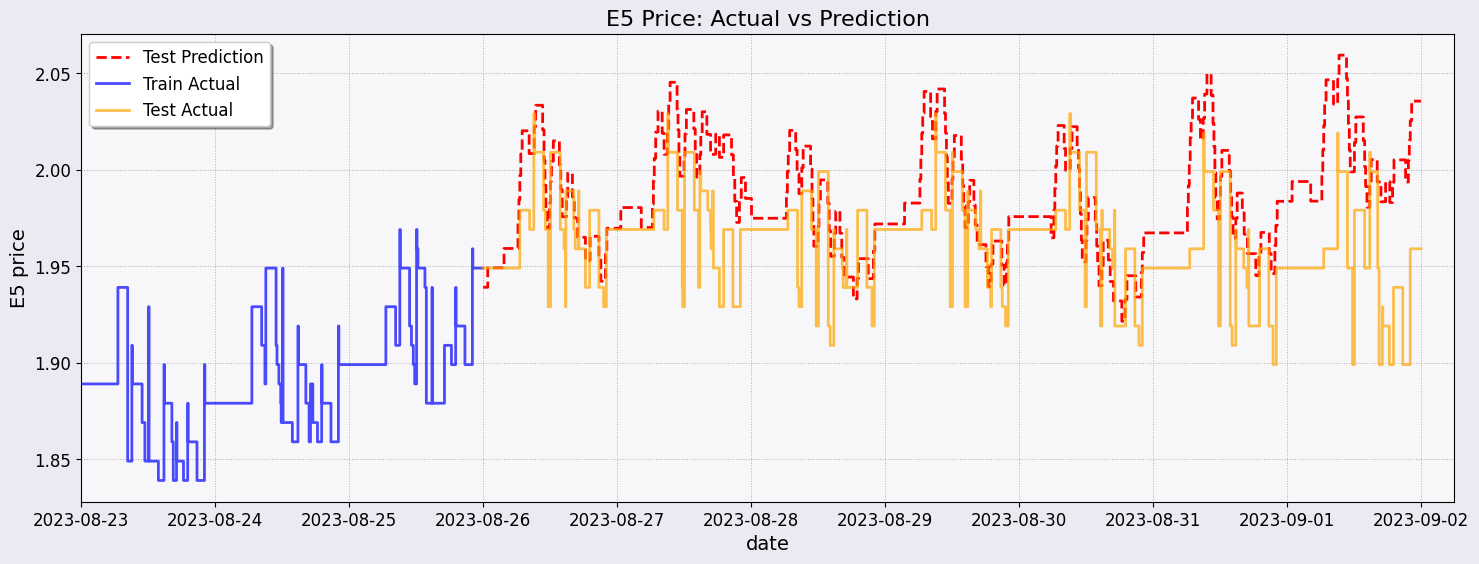

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/ypq1lvil.json


Successfully processed df01

Processing dataset: df02


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/hazyb_oy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40353', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/ypq1lvil.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/hazyb_oy.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model_d19yv88/prophet_model-20250619190616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:06:32 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 4.9657
1-Day RMSE in cent: 5.6107
1-Day r2-score: -2.6666
3-Day MAE in cent: 5.8509
3-Day RMSE in cent: 6.6575
3-Day r2-score: -3.7513
7-Day MAE in cent: 4.9552
7-Day RMSE in cent: 5.7745
7-Day r2-score: -2.1242


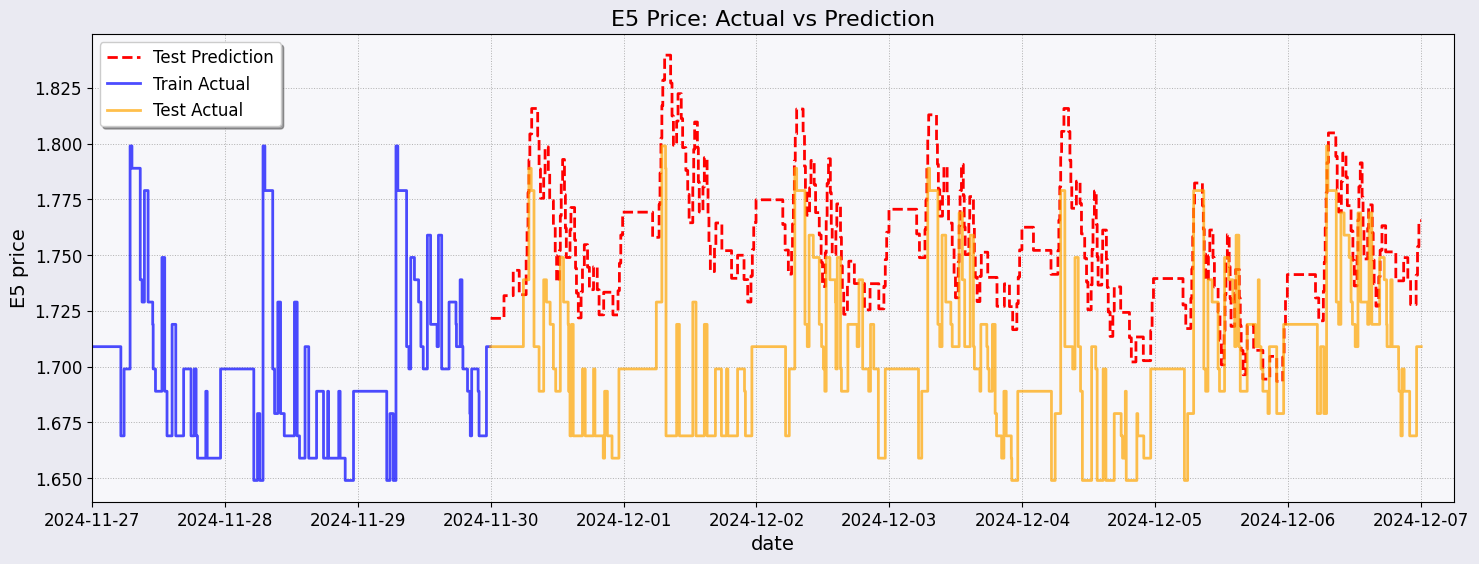

Successfully processed df02

Processing dataset: df03


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/wv7s1kma.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/2fmmnk78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46176', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/wv7s1kma.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/2fmmnk78.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model_ljw0ger/prophet_model-20250619190633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.4943
1-Day RMSE in cent: 1.8656
1-Day r2-score: 0.6114
3-Day MAE in cent: 1.5991
3-Day RMSE in cent: 1.9656
3-Day r2-score: 0.6283
7-Day MAE in cent: 2.2804
7-Day RMSE in cent: 2.8207
7-Day r2-score: 0.4514


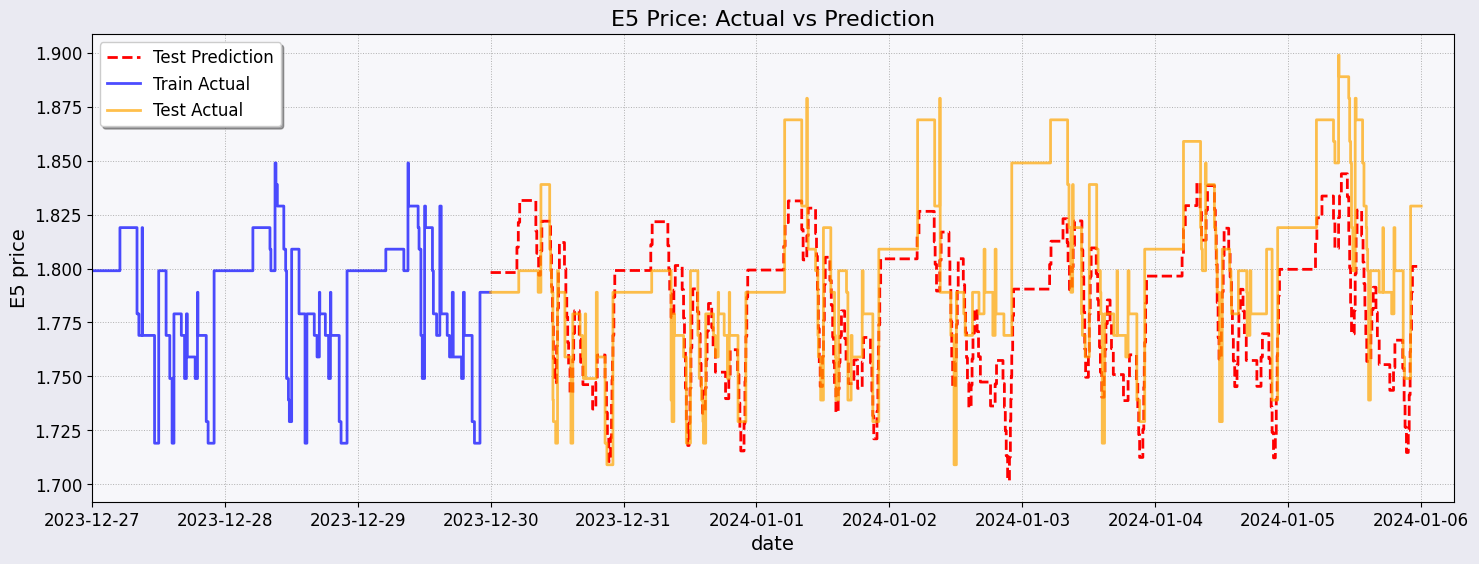

Successfully processed df03

Processing dataset: df04


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/hk0wulxa.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/ibv6dyap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67023', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/hk0wulxa.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/ibv6dyap.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modeldyalx00t/prophet_model-20250619190642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.2232
1-Day RMSE in cent: 1.7404
1-Day r2-score: 0.5253
3-Day MAE in cent: 1.7199
3-Day RMSE in cent: 2.3964
3-Day r2-score: 0.2784
7-Day MAE in cent: 1.6430
7-Day RMSE in cent: 2.2664
7-Day r2-score: 0.4673


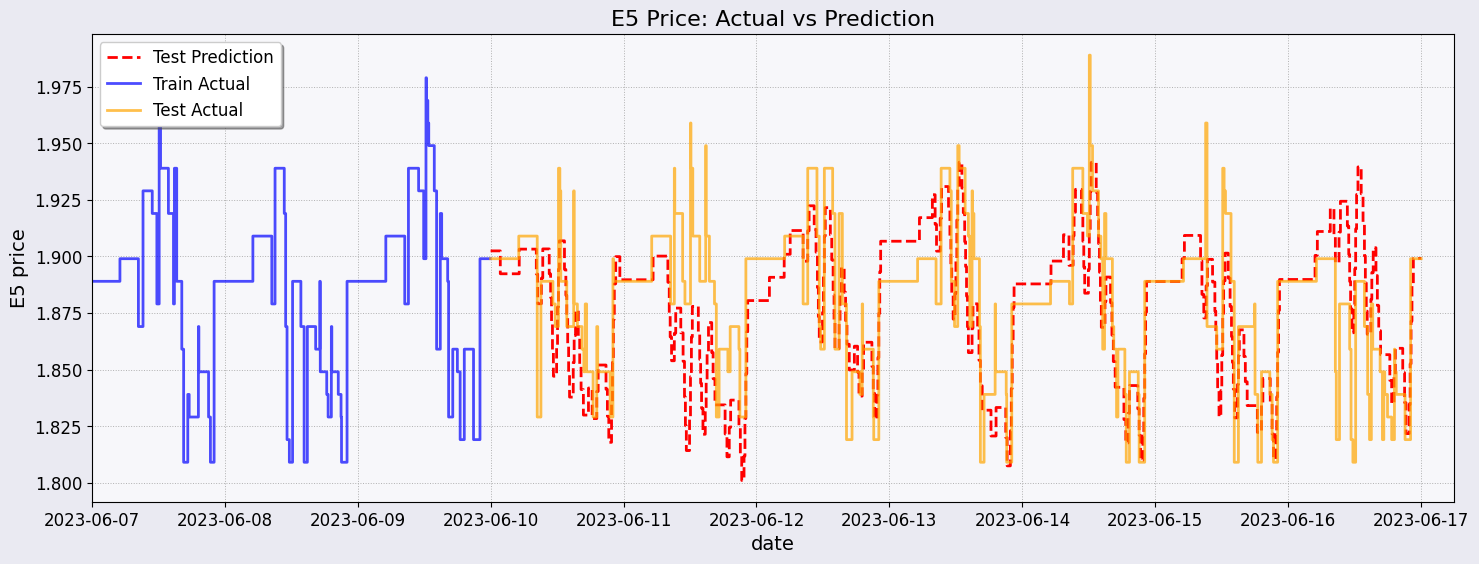

Successfully processed df04

Processing dataset: df05


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/f3m_wd9s.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/qzeqhcns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81981', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/f3m_wd9s.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/qzeqhcns.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelm78ccte2/prophet_model-20250619190704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 2.9118
1-Day RMSE in cent: 3.4361
1-Day r2-score: -0.6073
3-Day MAE in cent: 2.6405
3-Day RMSE in cent: 3.0144
3-Day r2-score: 0.5893
7-Day MAE in cent: 3.2767
7-Day RMSE in cent: 4.1338
7-Day r2-score: -0.0673


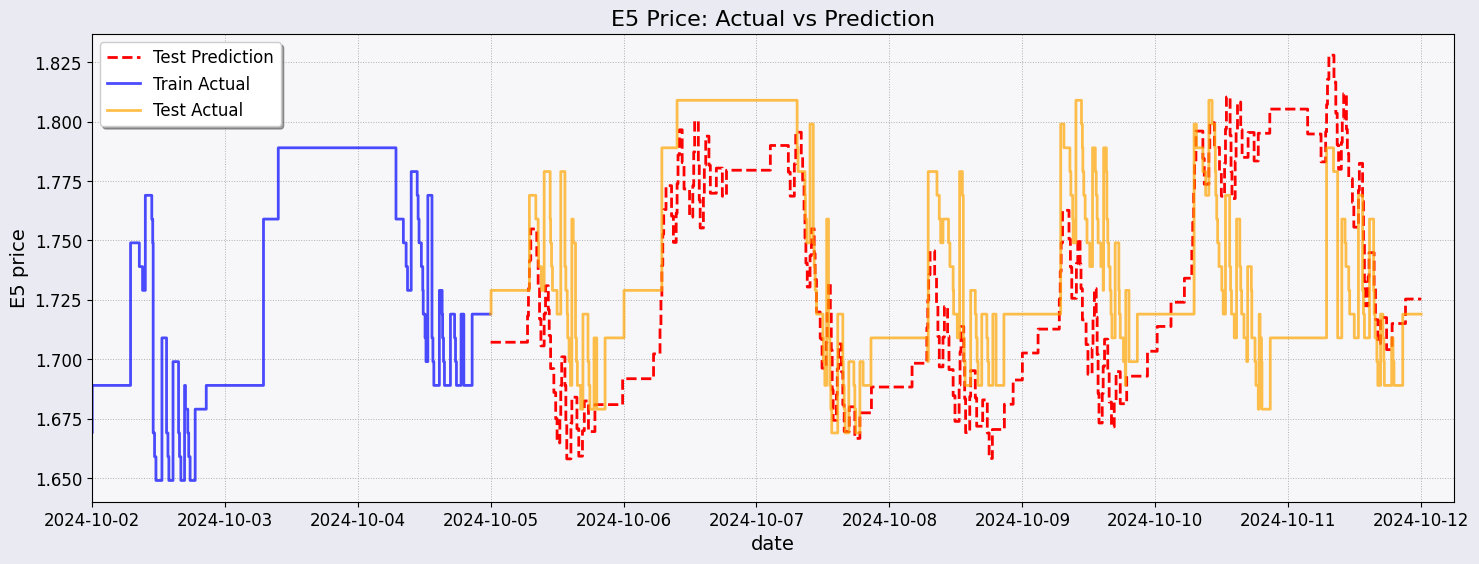

Successfully processed df05

Processing dataset: df06


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/xb7c3e4s.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/zcqhcacg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95197', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/xb7c3e4s.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/zcqhcacg.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelafxlc865/prophet_model-20250619190726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 2.1635
1-Day RMSE in cent: 2.6453
1-Day r2-score: 0.6023
3-Day MAE in cent: 3.3331
3-Day RMSE in cent: 4.2019
3-Day r2-score: -0.0606
7-Day MAE in cent: 3.3331
7-Day RMSE in cent: 4.2019
7-Day r2-score: -0.0606


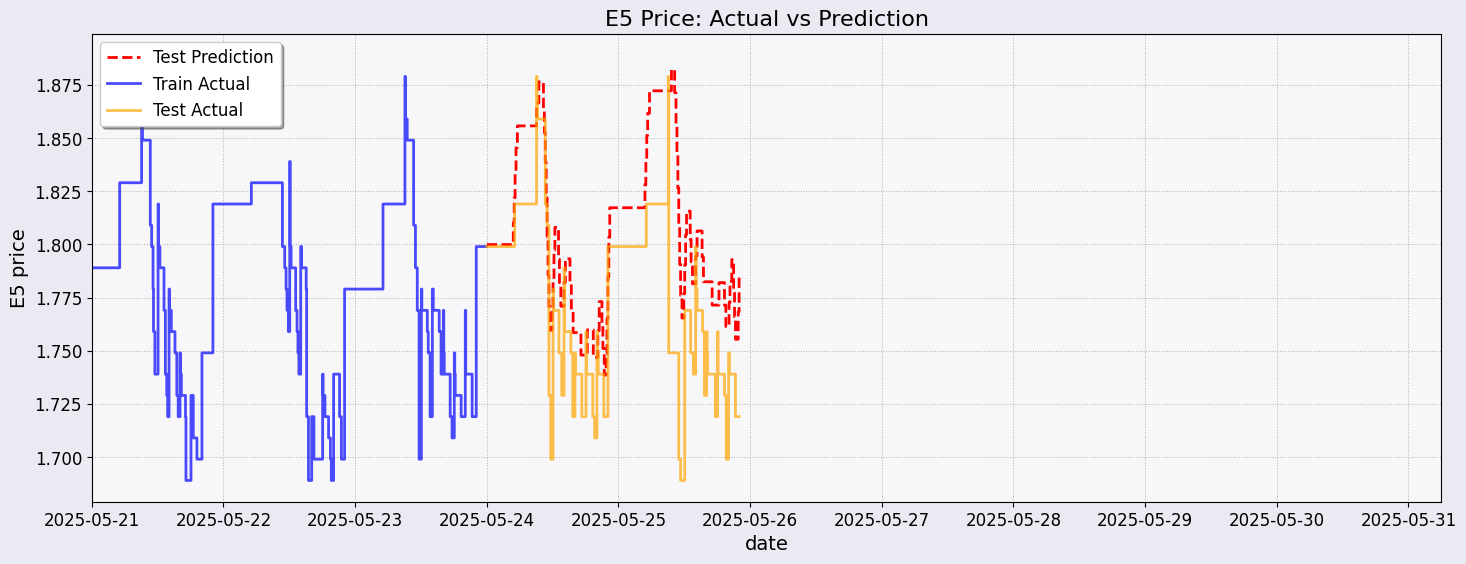

Successfully processed df06

Processing dataset: df07


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/rawi105e.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/fqxodyey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9348', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/rawi105e.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/fqxodyey.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model3wm7o5a_/prophet_model-20250619190743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

1-Day MAE in cent: 1.0929
1-Day RMSE in cent: 1.4805
1-Day r2-score: 0.7206
3-Day MAE in cent: 1.5164
3-Day RMSE in cent: 1.8996
3-Day r2-score: 0.6418
7-Day MAE in cent: 1.5986
7-Day RMSE in cent: 2.1216
7-Day r2-score: 0.4984


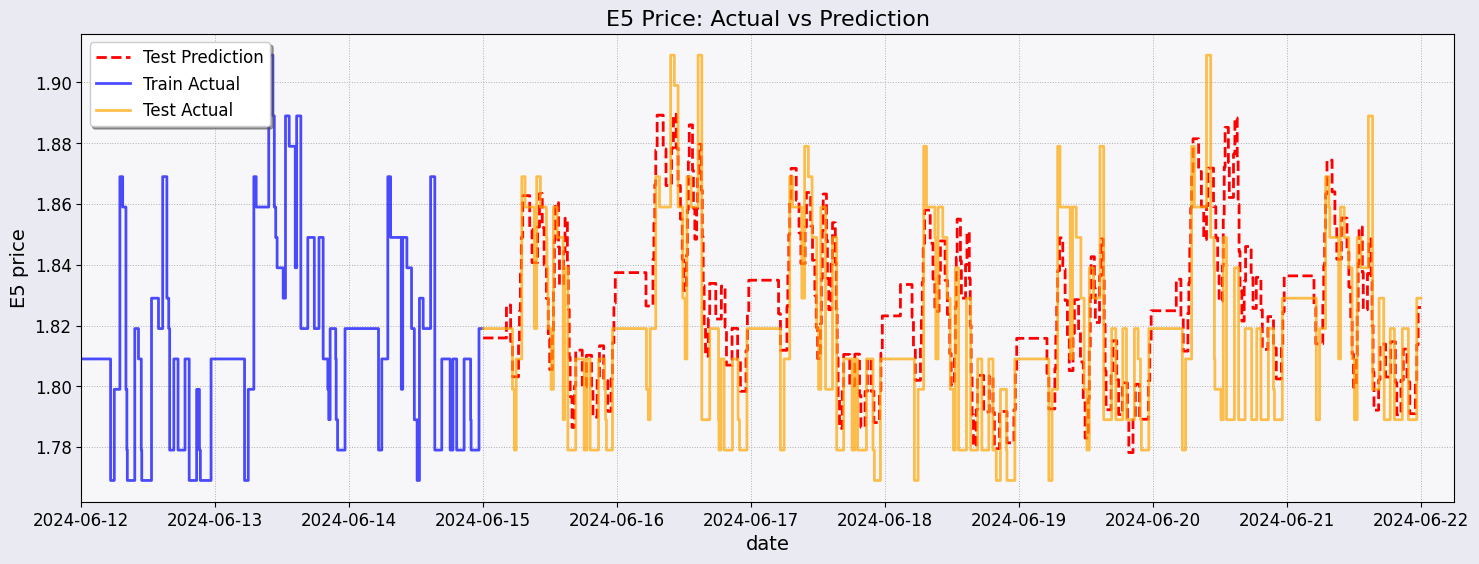

Successfully processed df07

Processing dataset: df08


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/4elnhrsh.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/p75rcdjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81575', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/4elnhrsh.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/p75rcdjk.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelbnwjyhcy/prophet_model-20250619190803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 2.3480
1-Day RMSE in cent: 2.7670
1-Day r2-score: 0.1445
3-Day MAE in cent: 2.2778
3-Day RMSE in cent: 2.6803
3-Day r2-score: 0.2279
7-Day MAE in cent: 1.9783
7-Day RMSE in cent: 2.6892
7-Day r2-score: 0.4588


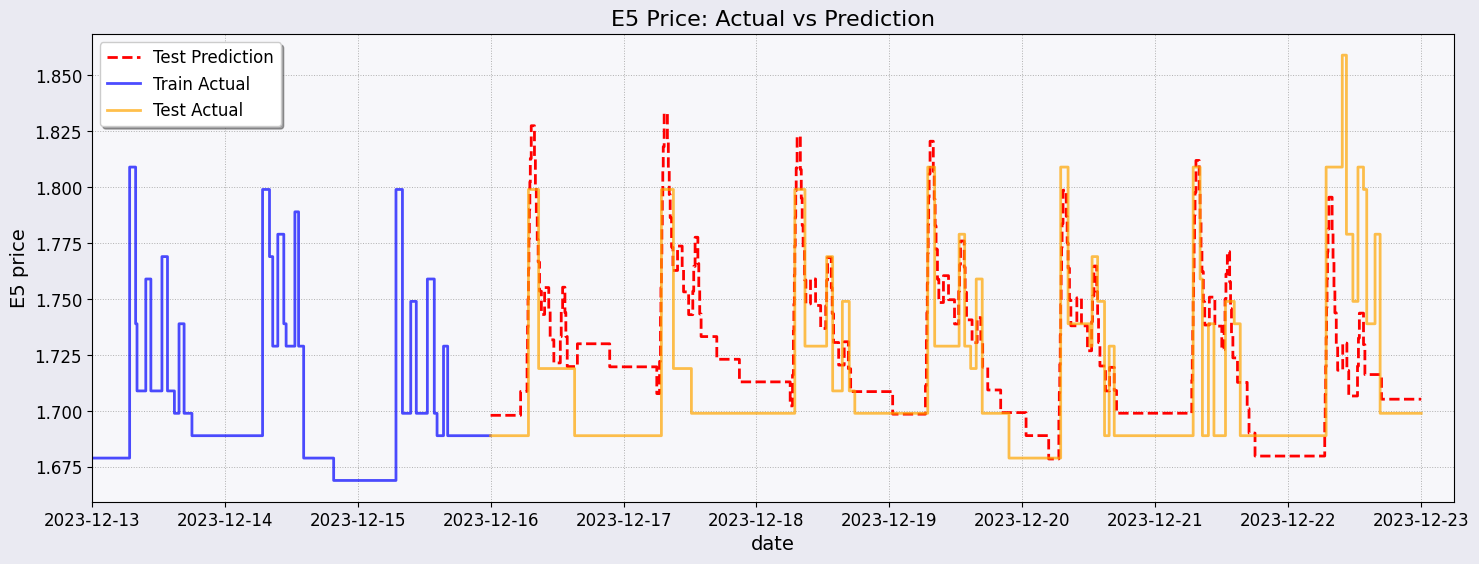

Successfully processed df08

Processing dataset: df09


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/r77lems_.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/sgmz209q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7173', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/r77lems_.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/sgmz209q.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelf0xdxjx5/prophet_model-20250619190825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

1-Day MAE in cent: 0.7409
1-Day RMSE in cent: 1.1453
1-Day r2-score: 0.8380
3-Day MAE in cent: 1.2598
3-Day RMSE in cent: 1.6561
3-Day r2-score: 0.6785
7-Day MAE in cent: 2.4626
7-Day RMSE in cent: 3.2099
7-Day r2-score: -0.2673


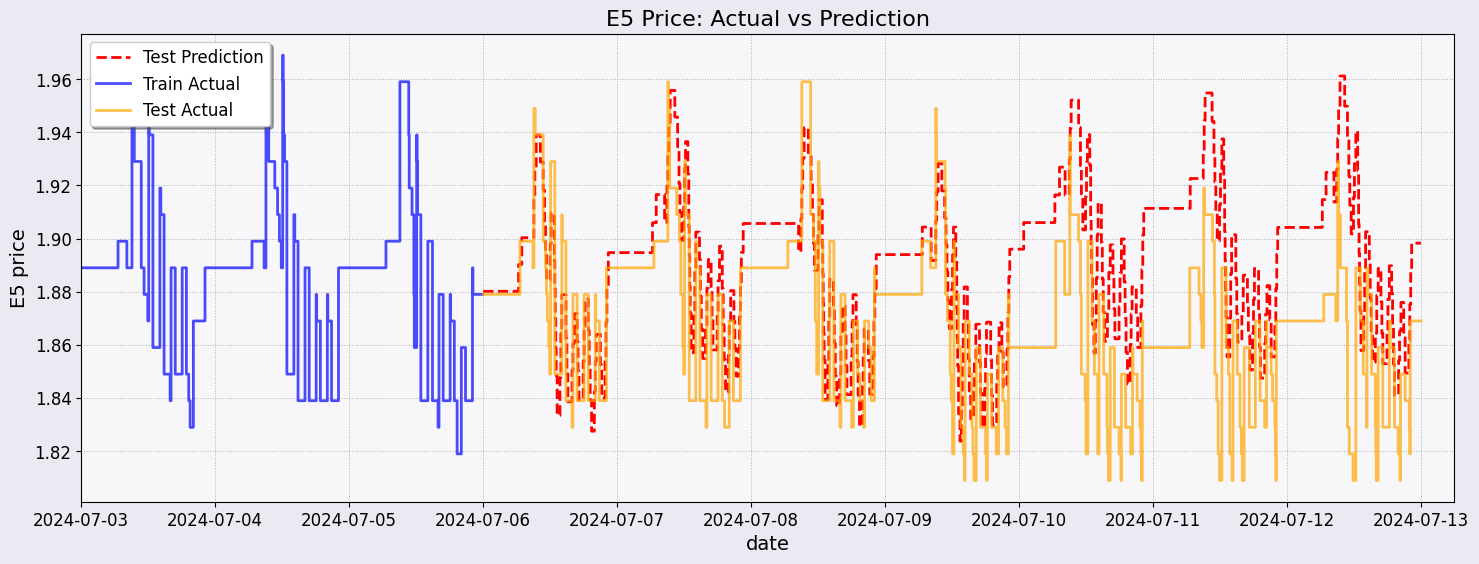

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/58gdlbch.json


Successfully processed df09

Processing dataset: df10


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/dq10em3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54014', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/58gdlbch.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/dq10em3x.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelkavjjm27/prophet_model-20250619190845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:09:02 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 2.0187
1-Day RMSE in cent: 2.6036
1-Day r2-score: 0.1133
3-Day MAE in cent: 3.8152
3-Day RMSE in cent: 4.3806
3-Day r2-score: -2.3697
7-Day MAE in cent: 4.0203
7-Day RMSE in cent: 4.4774
7-Day r2-score: -2.1131


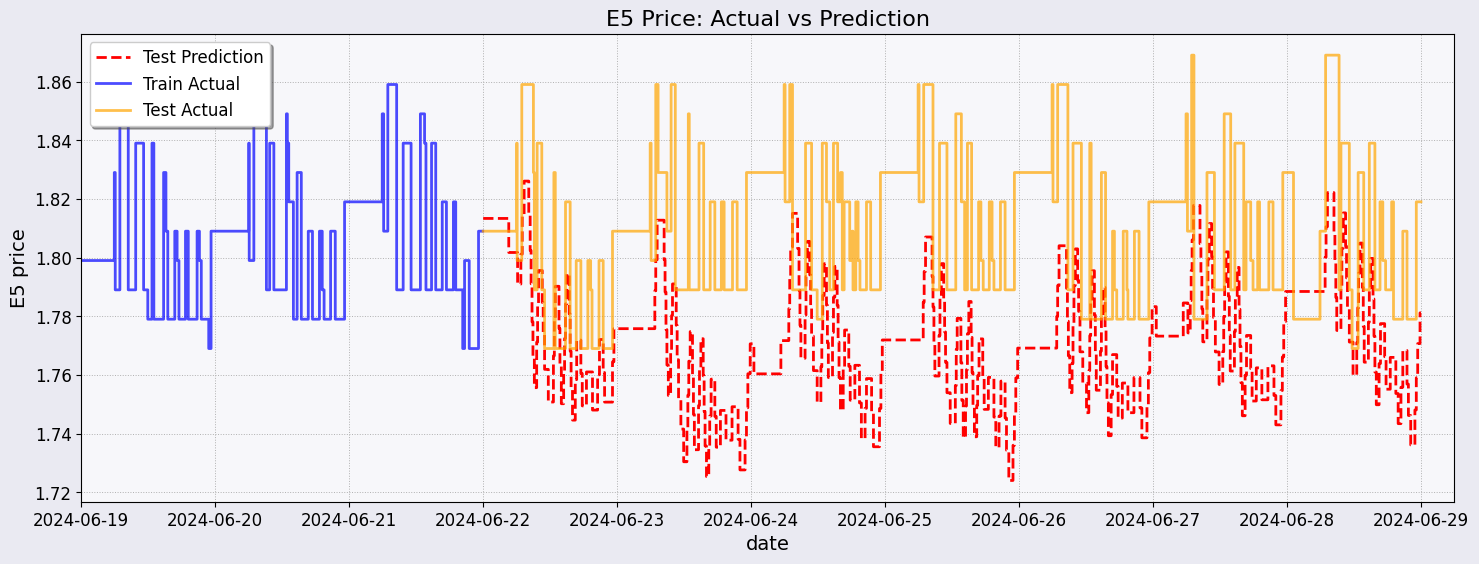

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/7z5ret26.json


Successfully processed df10

Processing dataset: df11


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/q2z9jiuv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30063', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/7z5ret26.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/q2z9jiuv.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model4hz0smr7/prophet_model-20250619190903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:09:24 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.6581
1-Day RMSE in cent: 2.1585
1-Day r2-score: 0.6781
3-Day MAE in cent: 3.2948
3-Day RMSE in cent: 3.9398
3-Day r2-score: -0.3092
7-Day MAE in cent: 5.1670
7-Day RMSE in cent: 5.9043
7-Day r2-score: -0.5821


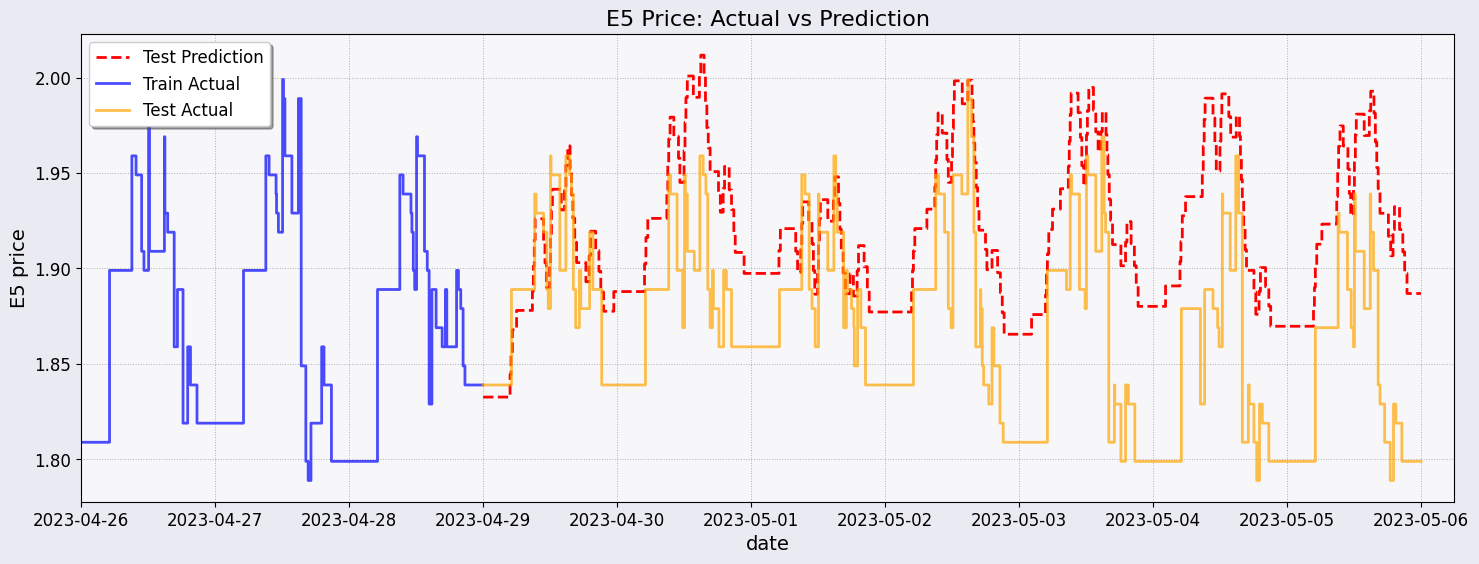

Successfully processed df11

Processing dataset: df12


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/nu6o2fx9.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/24z0f131.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76446', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/nu6o2fx9.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/24z0f131.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model68lajmi3/prophet_model-20250619190925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.5856
1-Day RMSE in cent: 1.8756
1-Day r2-score: 0.7475
3-Day MAE in cent: 1.3226
3-Day RMSE in cent: 1.7010
3-Day r2-score: 0.7777
7-Day MAE in cent: 1.2255
7-Day RMSE in cent: 1.6079
7-Day r2-score: 0.7492


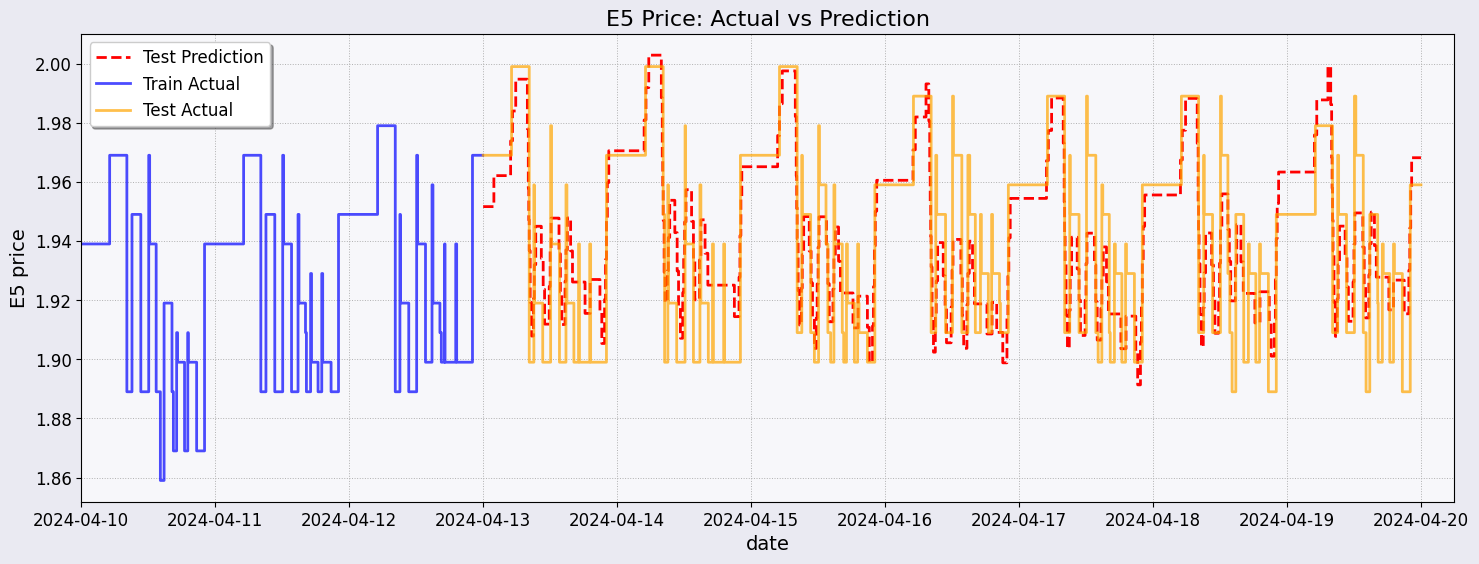

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/g0so0vzg.json


Successfully processed df12

Processing dataset: df13


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/o5i2a53d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62873', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/g0so0vzg.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/o5i2a53d.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model04zsbjj4/prophet_model-20250619190943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:10:04 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.2222
1-Day RMSE in cent: 1.7615
1-Day r2-score: 0.6768
3-Day MAE in cent: 1.6977
3-Day RMSE in cent: 2.0733
3-Day r2-score: 0.5441
7-Day MAE in cent: 2.5787
7-Day RMSE in cent: 3.0651
7-Day r2-score: 0.1676


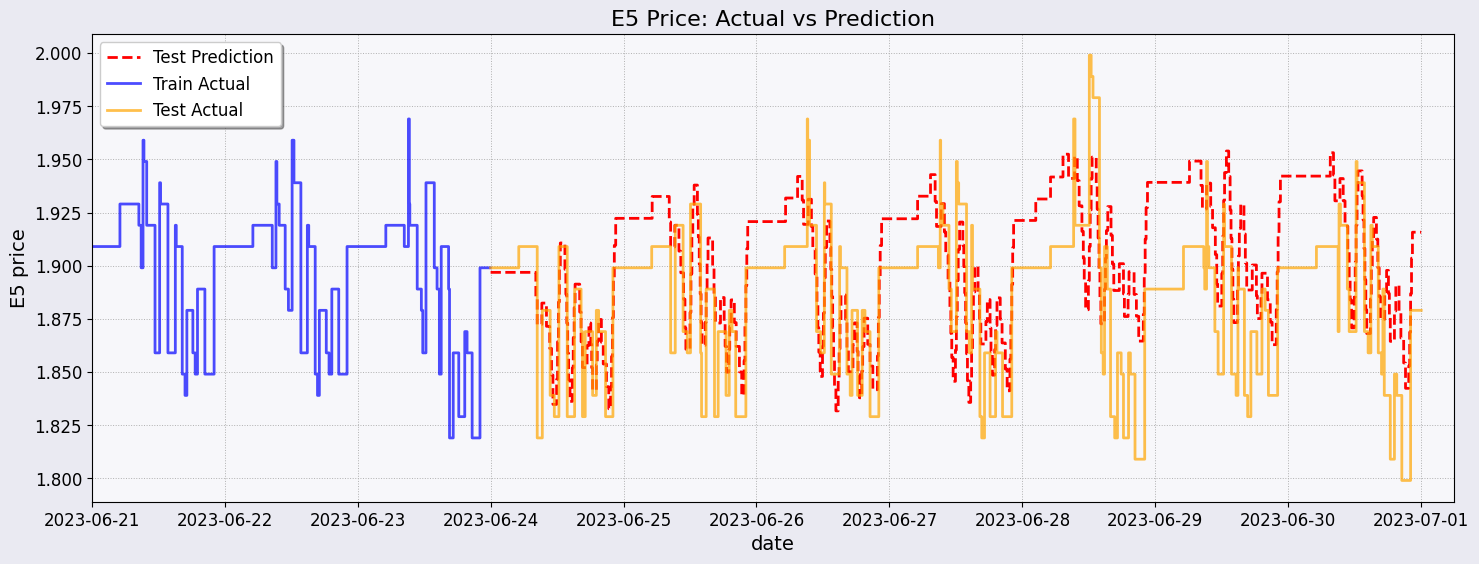

Successfully processed df13

Processing dataset: df14


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/5sddwpv2.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/jj5ghpjq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45602', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/5sddwpv2.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/jj5ghpjq.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelcjra_pmi/prophet_model-20250619191005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 0.9241
1-Day RMSE in cent: 1.4920
1-Day r2-score: 0.7984
3-Day MAE in cent: 1.4469
3-Day RMSE in cent: 2.0742
3-Day r2-score: 0.6050
7-Day MAE in cent: 1.4157
7-Day RMSE in cent: 2.0587
7-Day r2-score: 0.6807


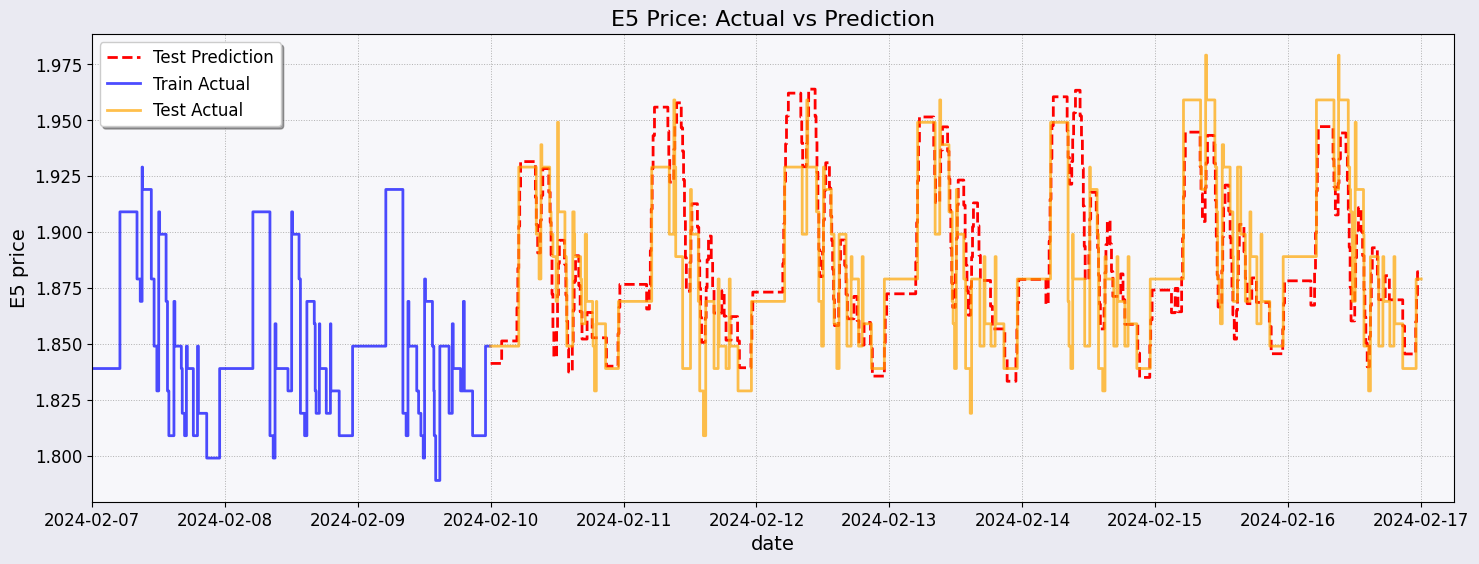

Successfully processed df14

Processing dataset: df15


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/w7r4p65b.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/emeo1w9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5558', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/w7r4p65b.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/emeo1w9j.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model4xj6f_z0/prophet_model-20250619191024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

1-Day MAE in cent: 1.0281
1-Day RMSE in cent: 1.4006
1-Day r2-score: 0.8503
3-Day MAE in cent: 2.0646
3-Day RMSE in cent: 2.6984
3-Day r2-score: 0.6329
7-Day MAE in cent: 2.1363
7-Day RMSE in cent: 2.6517
7-Day r2-score: 0.5978


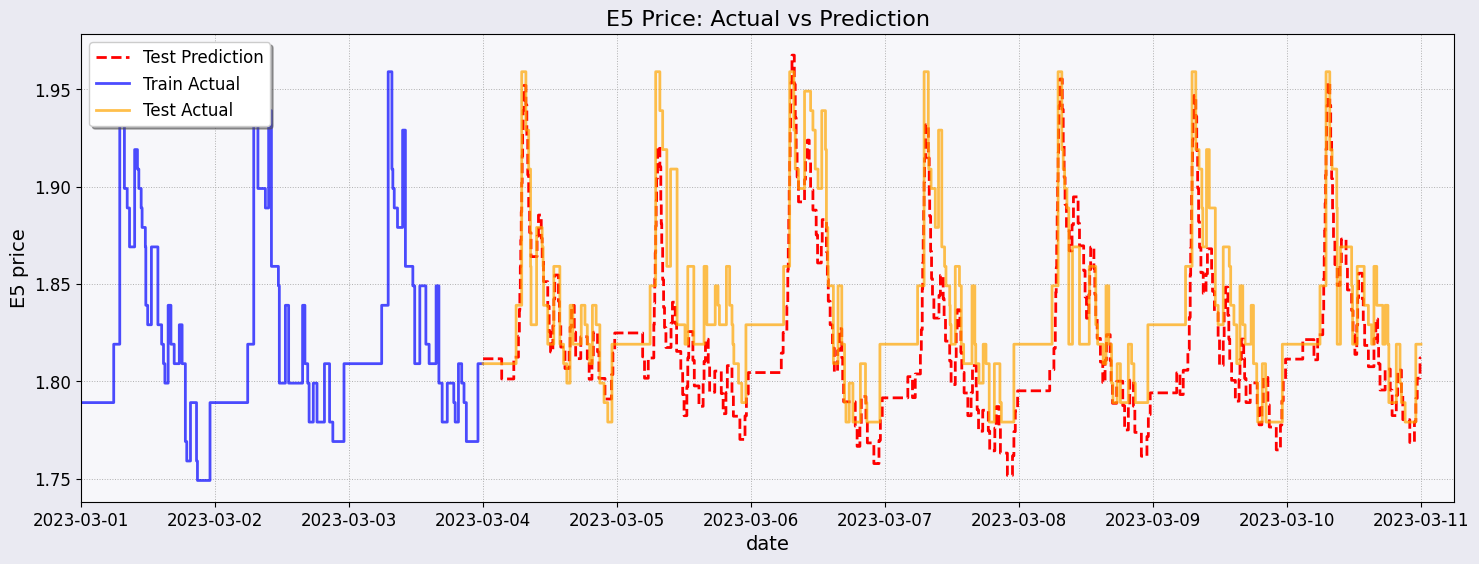

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/nj61emgh.json


Successfully processed df15

Processing dataset: df16


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/w7wjj0xe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54603', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/nj61emgh.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/w7wjj0xe.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelh2cz_g9o/prophet_model-20250619191046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:11:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:11:03 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.3226
1-Day RMSE in cent: 1.7641
1-Day r2-score: 0.6744
3-Day MAE in cent: 1.3782
3-Day RMSE in cent: 1.7814
3-Day r2-score: 0.6948
7-Day MAE in cent: 1.8300
7-Day RMSE in cent: 2.3867
7-Day r2-score: 0.4602


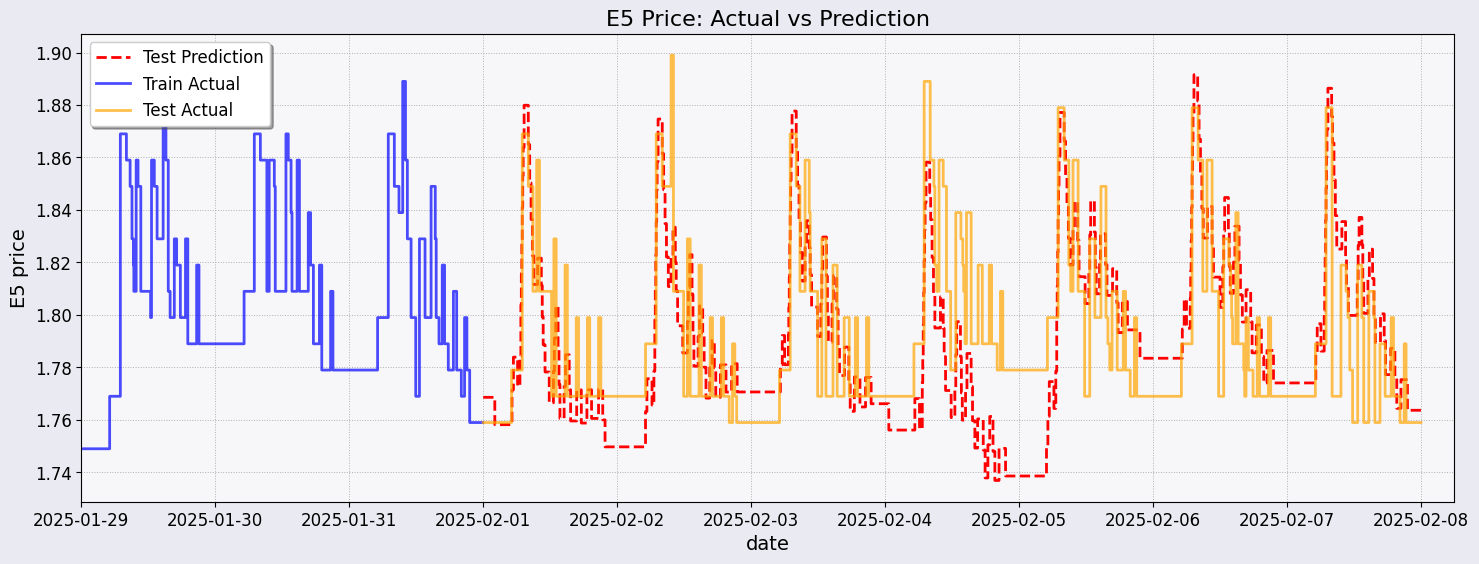

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/74ik4brd.json


Successfully processed df16

Processing dataset: df17


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/r5501zdd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23109', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/74ik4brd.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/r5501zdd.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modela5yube9i/prophet_model-20250619191104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:11:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:11:25 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.7086
1-Day RMSE in cent: 2.1307
1-Day r2-score: 0.7706
3-Day MAE in cent: 2.3798
3-Day RMSE in cent: 2.9220
3-Day r2-score: 0.5650
7-Day MAE in cent: 2.1659
7-Day RMSE in cent: 2.6137
7-Day r2-score: 0.6603


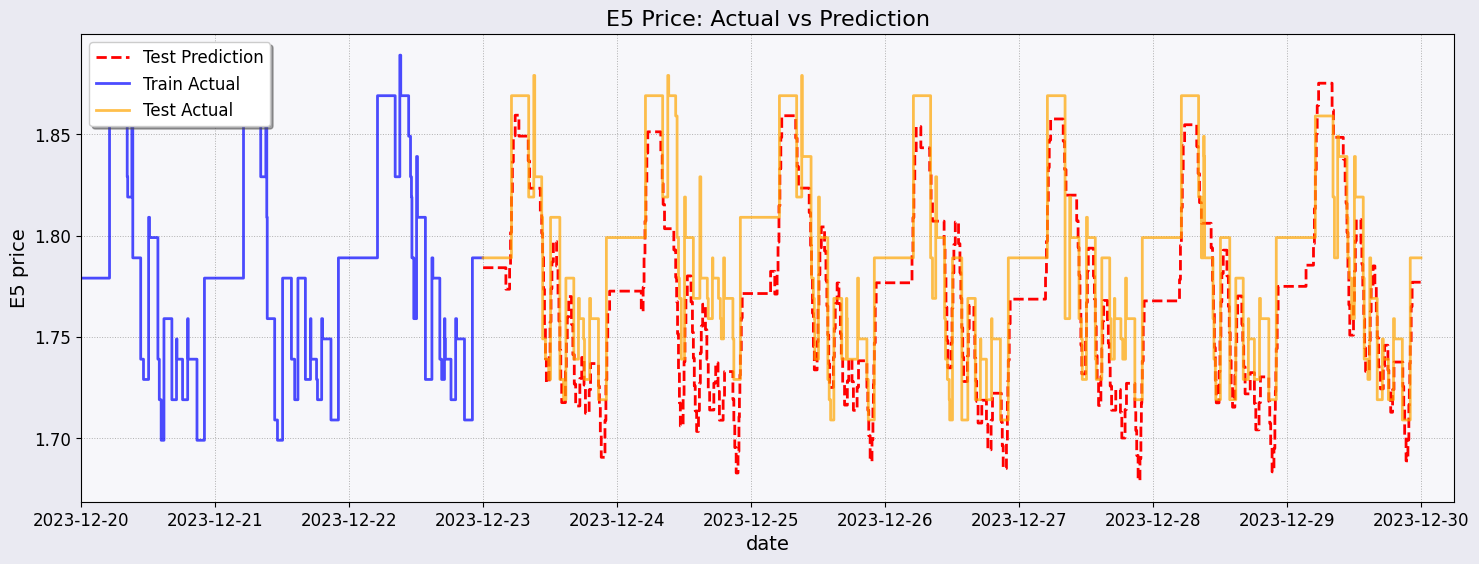

Successfully processed df17

Processing dataset: df18


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/j1mh7z1j.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/7scviniw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65612', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/j1mh7z1j.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/7scviniw.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelgsbqe61s/prophet_model-20250619191126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.0570
1-Day RMSE in cent: 1.4841
1-Day r2-score: 0.7864
3-Day MAE in cent: 1.4885
3-Day RMSE in cent: 2.0572
3-Day r2-score: 0.6213
7-Day MAE in cent: 1.6011
7-Day RMSE in cent: 2.2455
7-Day r2-score: 0.6220


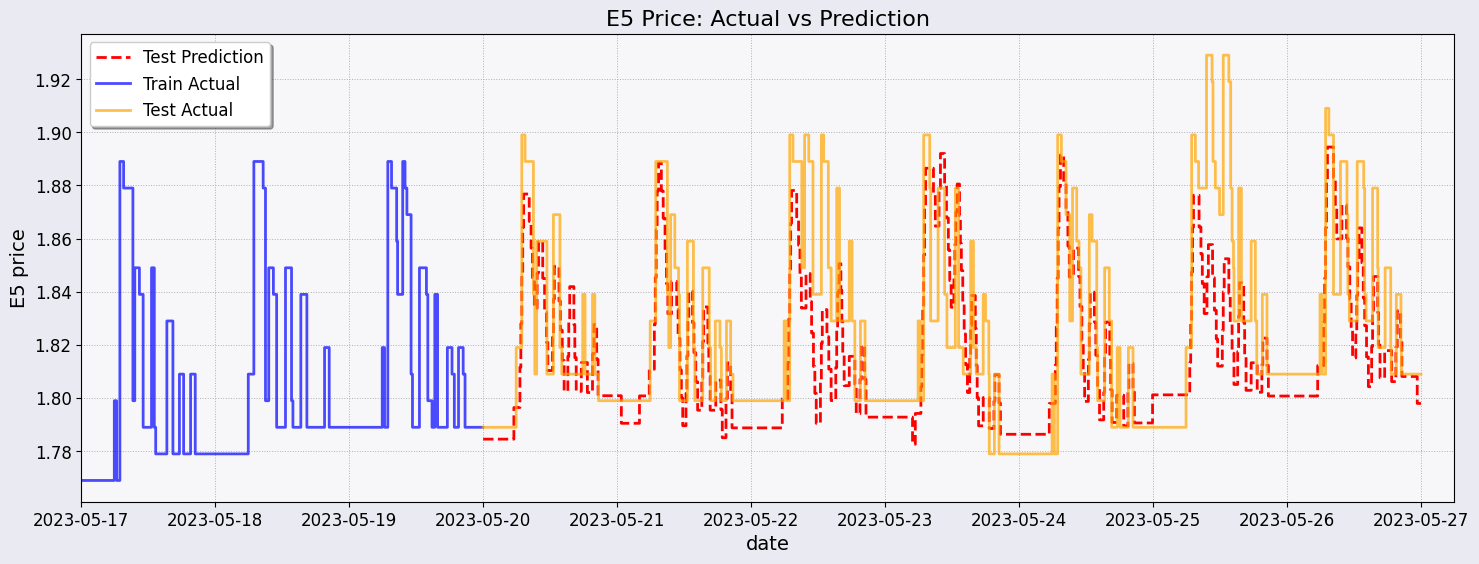

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/s6eisi9t.json


Successfully processed df18

Processing dataset: df19


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/7urv_7fz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11006', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/s6eisi9t.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/7urv_7fz.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model19hwbh1s/prophet_model-20250619191146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:12:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:12:09 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 0.5542
1-Day RMSE in cent: 0.5695
1-Day r2-score: -0.5190
3-Day MAE in cent: 0.6127
3-Day RMSE in cent: 0.6187
3-Day r2-score: -3.1434
7-Day MAE in cent: 0.8387
7-Day RMSE in cent: 1.0134
7-Day r2-score: -0.9659


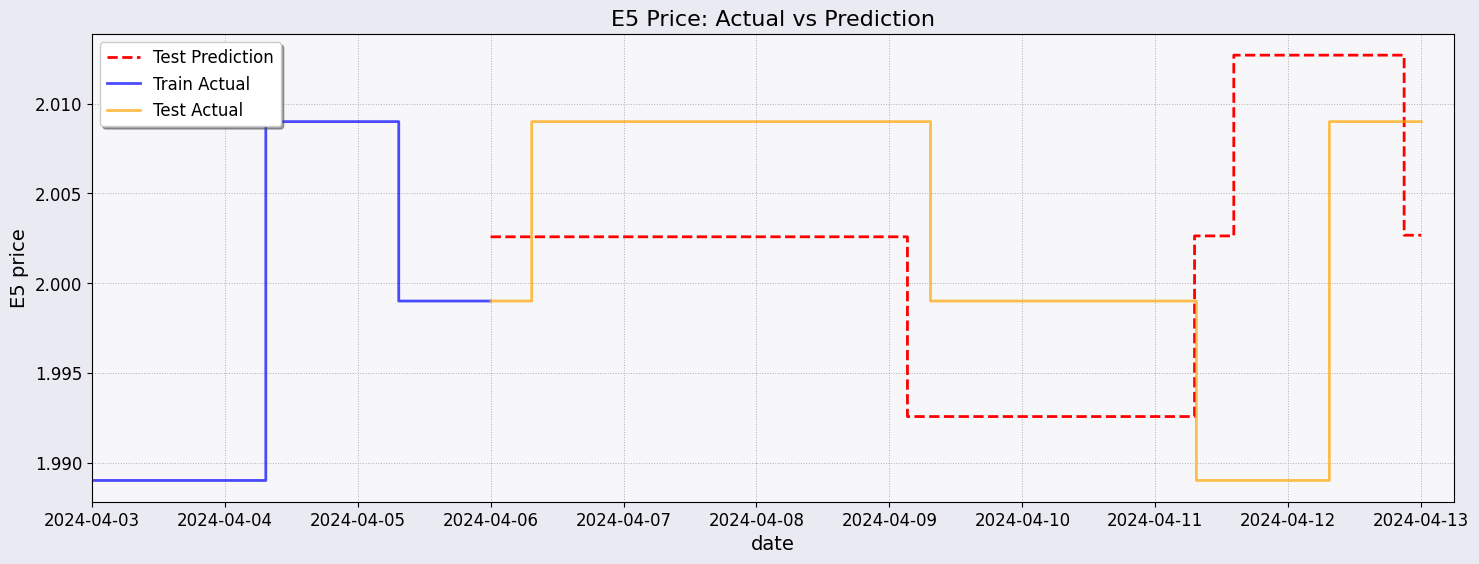

Successfully processed df19

Processing dataset: df20


2025/06/19 19:12:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1-Day MAE in cent: 0.0000
1-Day RMSE in cent: 0.0000
1-Day r2-score: 1.0000
3-Day MAE in cent: 0.0000
3-Day RMSE in cent: 0.0000
3-Day r2-score: 1.0000
7-Day MAE in cent: 0.0000
7-Day RMSE in cent: 0.0000
7-Day r2-score: 1.0000


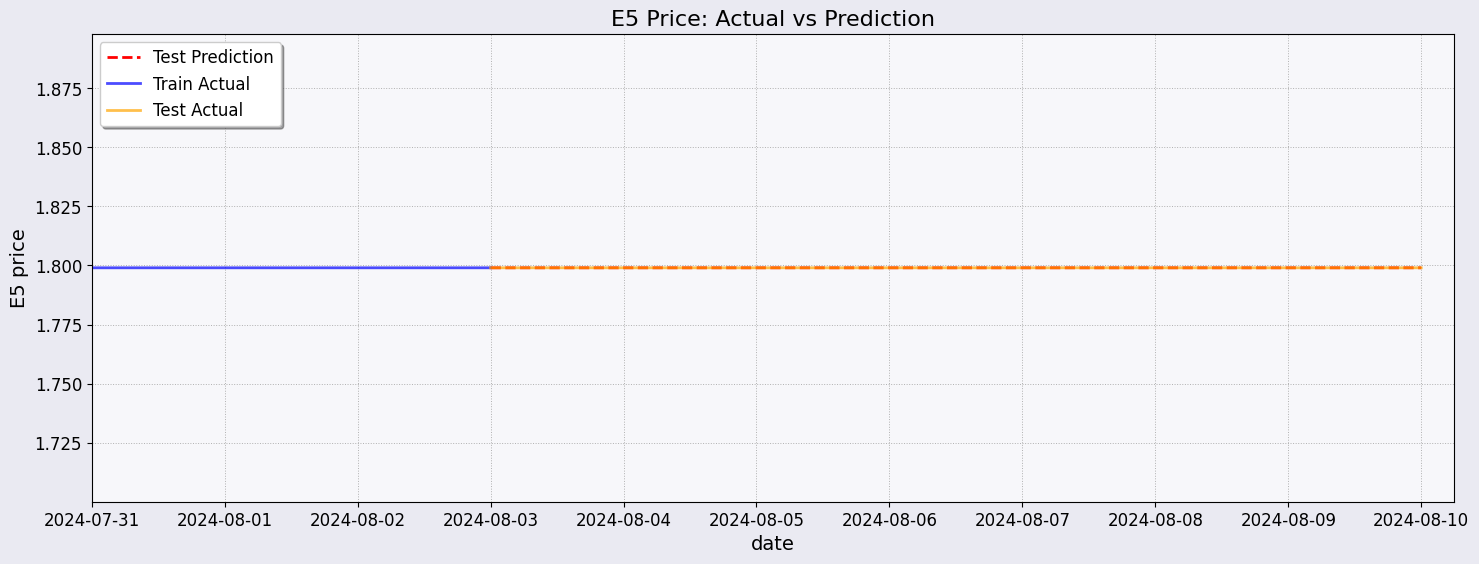

Successfully processed df20

Processing dataset: df21


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/qnq27fs6.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/f86kuz8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28401', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/qnq27fs6.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/f86kuz8o.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelcn6xunmd/prophet_model-20250619191212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:12:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:12:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.0495
1-Day RMSE in cent: 1.3921
1-Day r2-score: 0.5675
3-Day MAE in cent: 1.1639
3-Day RMSE in cent: 1.6443
3-Day r2-score: 0.3000
7-Day MAE in cent: 3.7451
7-Day RMSE in cent: 4.7079
7-Day r2-score: -4.4425


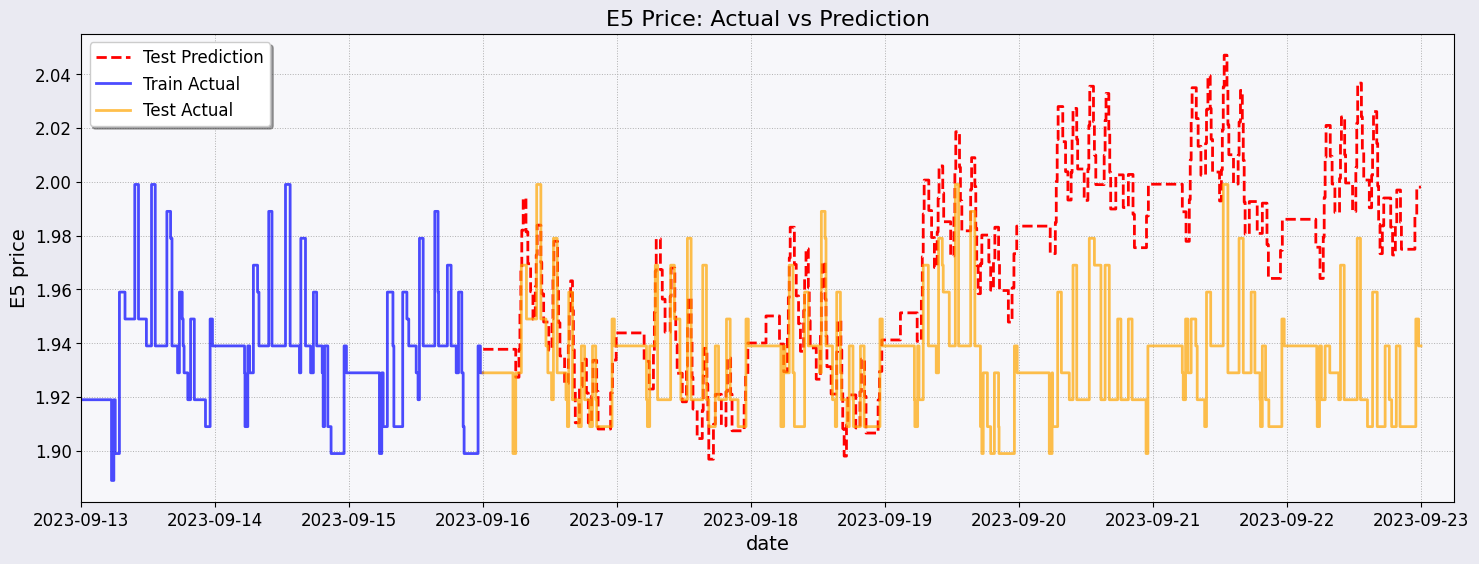

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/2qajwxo7.json


Successfully processed df21

Processing dataset: df22


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/29k8hl1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89902', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/2qajwxo7.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/29k8hl1e.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelmgcj5k69/prophet_model-20250619191232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:12:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:12:54 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 3.2089
1-Day RMSE in cent: 4.1920
1-Day r2-score: -1.7831
3-Day MAE in cent: 2.7914
3-Day RMSE in cent: 3.6767
3-Day r2-score: -0.7783
7-Day MAE in cent: 3.1650
7-Day RMSE in cent: 3.9349
7-Day r2-score: -0.7107


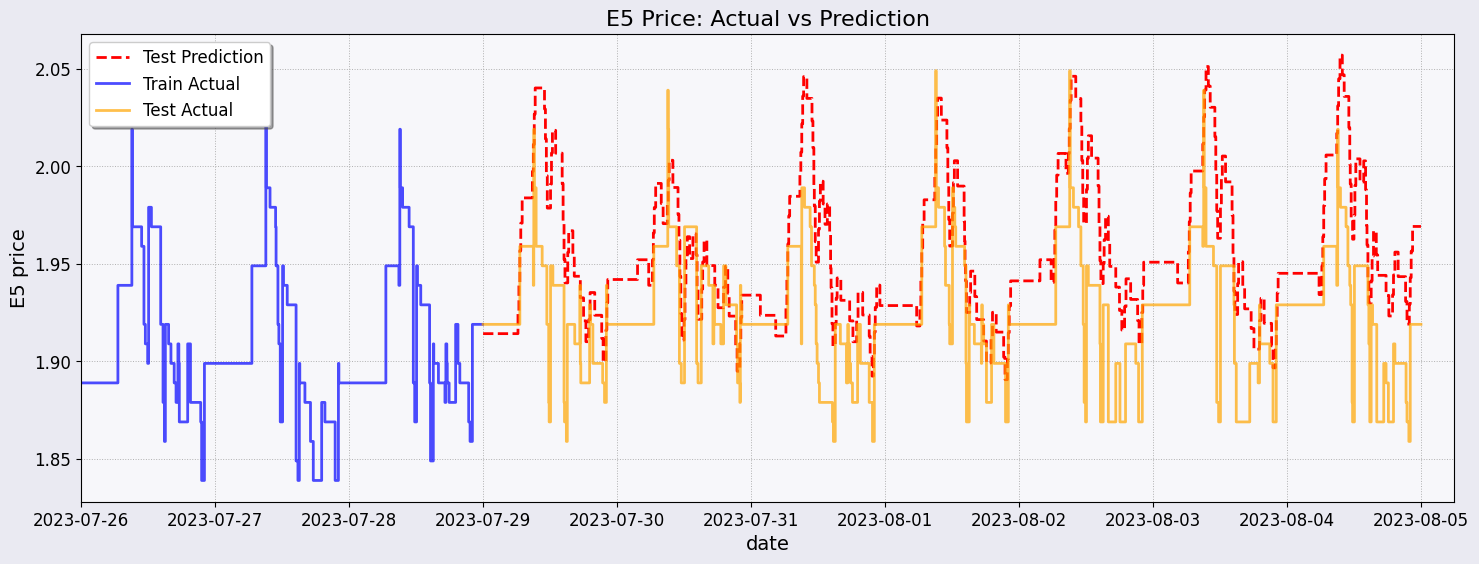

Successfully processed df22

Processing dataset: df23


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/dvfixoqi.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/bf68q5mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86259', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/dvfixoqi.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/bf68q5mo.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_model3yi7qo2x/prophet_model-20250619191255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:12:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 3.9361
1-Day RMSE in cent: 4.3083
1-Day r2-score: -1.0325
3-Day MAE in cent: 4.6189
3-Day RMSE in cent: 4.8817
3-Day r2-score: -1.8328
7-Day MAE in cent: 5.9714
7-Day RMSE in cent: 6.3274
7-Day r2-score: -3.7337


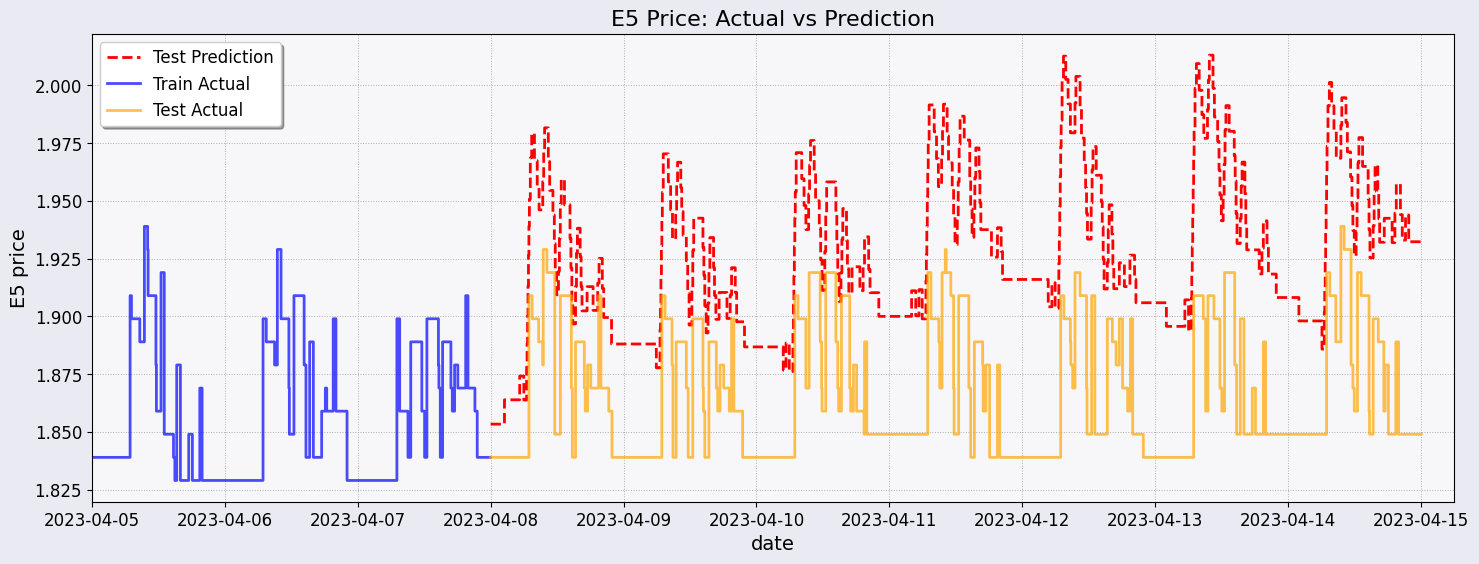

Successfully processed df23

Processing dataset: df24


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/_89r7xs3.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/a21_kvxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98256', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/_89r7xs3.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/a21_kvxp.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modeluseh2sdx/prophet_model-20250619191317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 2.6024
1-Day RMSE in cent: 3.3378
1-Day r2-score: 0.3115
3-Day MAE in cent: 5.8457
3-Day RMSE in cent: 6.5952
3-Day r2-score: -1.2171
7-Day MAE in cent: 5.3427
7-Day RMSE in cent: 6.0607
7-Day r2-score: -0.4068


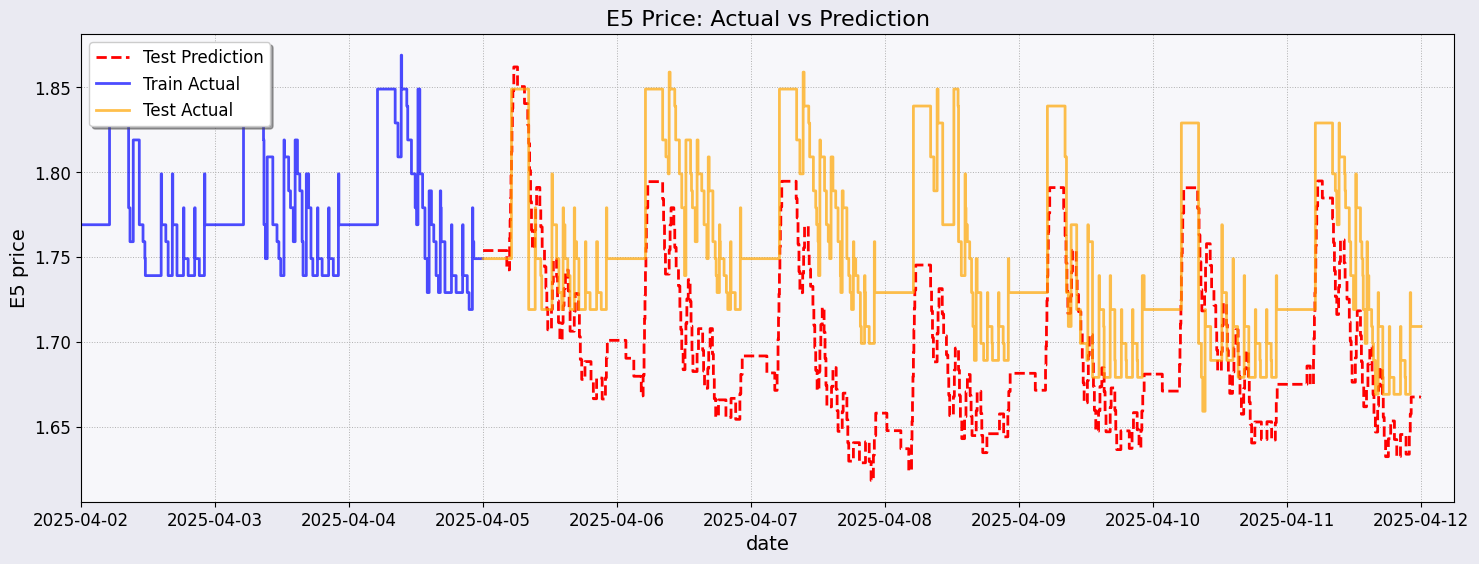

Successfully processed df24

Processing dataset: df25


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/i3ks2d7f.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/irswetxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77954', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/i3ks2d7f.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/irswetxe.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelv8f18tex/prophet_model-20250619191339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:13:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:13:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 3.2021
1-Day RMSE in cent: 3.6512
1-Day r2-score: -0.7044
3-Day MAE in cent: 5.3468
3-Day RMSE in cent: 5.7893
3-Day r2-score: -2.6063
7-Day MAE in cent: 6.1924
7-Day RMSE in cent: 6.5712
7-Day r2-score: -3.8183


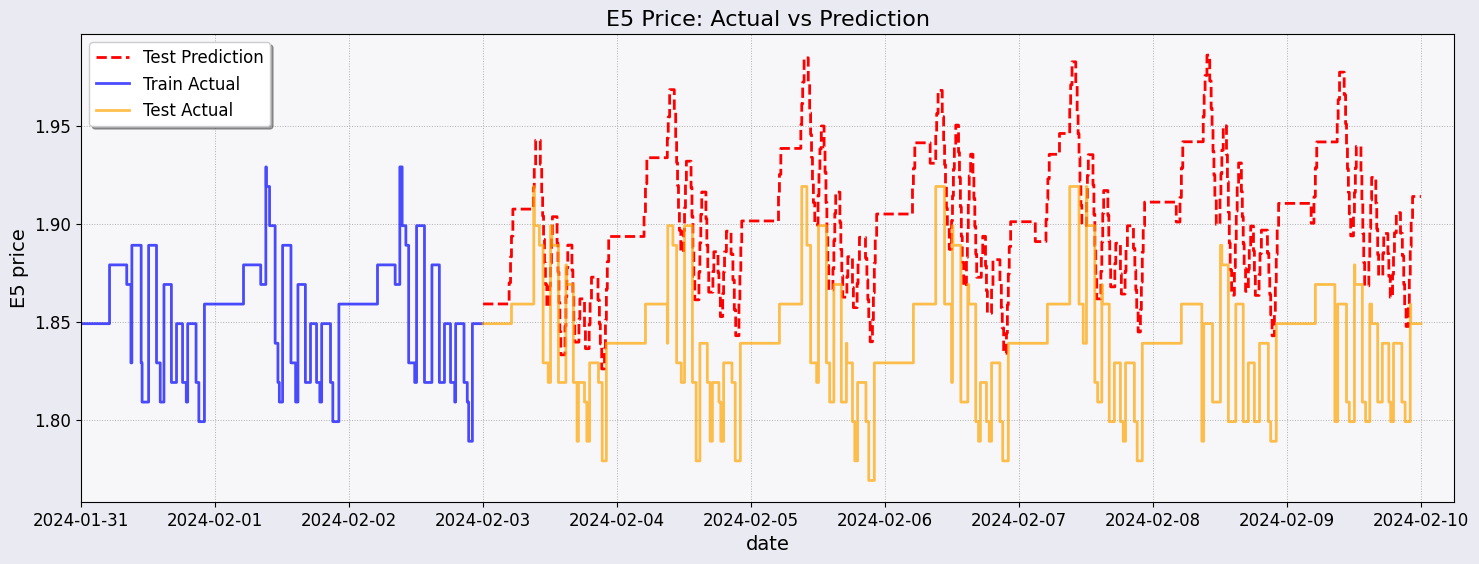

Successfully processed df25

Processing dataset: df26


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/mqhq4tkt.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/ntt2e0w1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82932', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/mqhq4tkt.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/ntt2e0w1.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelm0q9fof0/prophet_model-20250619191401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 2.4207
1-Day RMSE in cent: 3.0323
1-Day r2-score: 0.5289
3-Day MAE in cent: 1.9168
3-Day RMSE in cent: 2.4839
3-Day r2-score: 0.6881
7-Day MAE in cent: 2.9565
7-Day RMSE in cent: 3.7275
7-Day r2-score: 0.2572


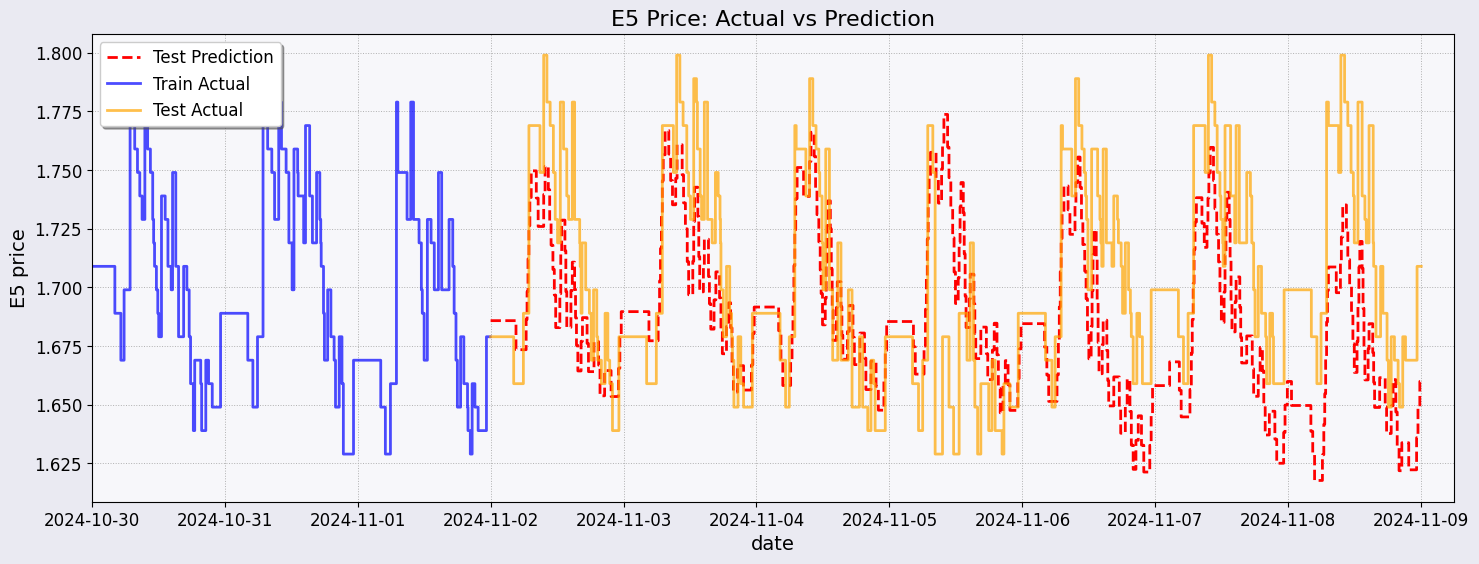

Successfully processed df26

Processing dataset: df27


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/zmr681mj.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/ad60zt2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30060', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/zmr681mj.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/ad60zt2r.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelr6sh1jeb/prophet_model-20250619191423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 2.7459
1-Day RMSE in cent: 3.3662
1-Day r2-score: 0.0615
3-Day MAE in cent: 3.8714
3-Day RMSE in cent: 4.4983
3-Day r2-score: -0.3860
7-Day MAE in cent: 4.5054
7-Day RMSE in cent: 5.2297
7-Day r2-score: -0.3398


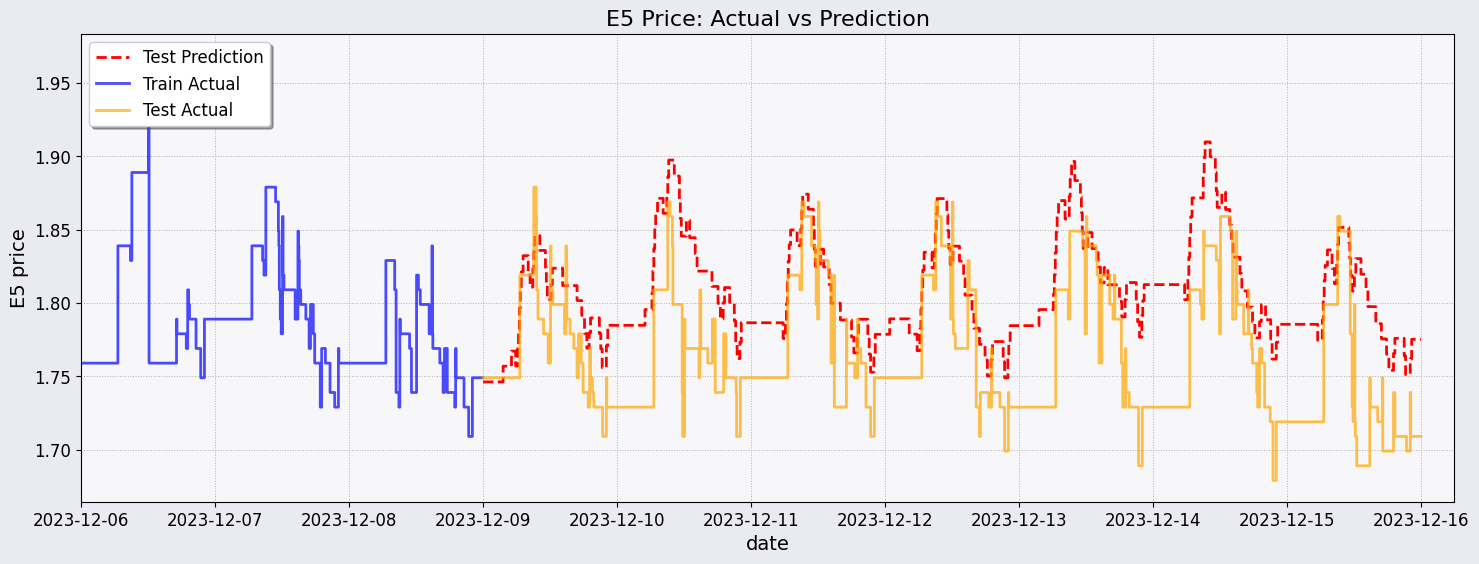

Successfully processed df27

Processing dataset: df28


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/0b1dxk23.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/di7m8iaj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26250', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/0b1dxk23.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/di7m8iaj.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelqr1zolwm/prophet_model-20250619191443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.4382
1-Day RMSE in cent: 2.0215
1-Day r2-score: 0.5973
3-Day MAE in cent: 1.7158
3-Day RMSE in cent: 2.6156
3-Day r2-score: 0.3227
7-Day MAE in cent: 2.4301
7-Day RMSE in cent: 3.1137
7-Day r2-score: 0.3131


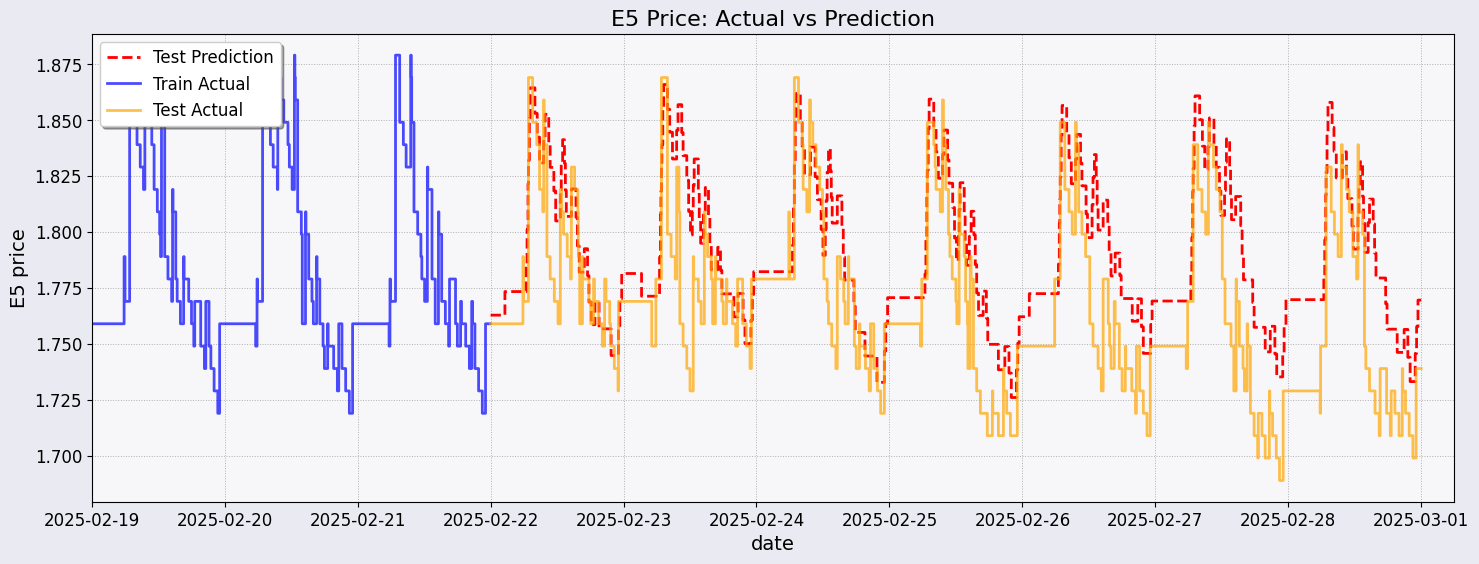

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/2w7aulzh.json


Successfully processed df28

Processing dataset: df29


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/7jt6oagh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66527', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/2w7aulzh.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/7jt6oagh.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelakxei2uh/prophet_model-20250619191505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:15:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/19 19:15:27 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 0.9397
1-Day RMSE in cent: 1.0932
1-Day r2-score: -2424101129035777676077432832.0000
3-Day MAE in cent: 0.7479
3-Day RMSE in cent: 0.9473
3-Day r2-score: -202226219746056436134707200.0000
7-Day MAE in cent: 0.7470
7-Day RMSE in cent: 0.9429
7-Day r2-score: -200340883542771321656049664.0000


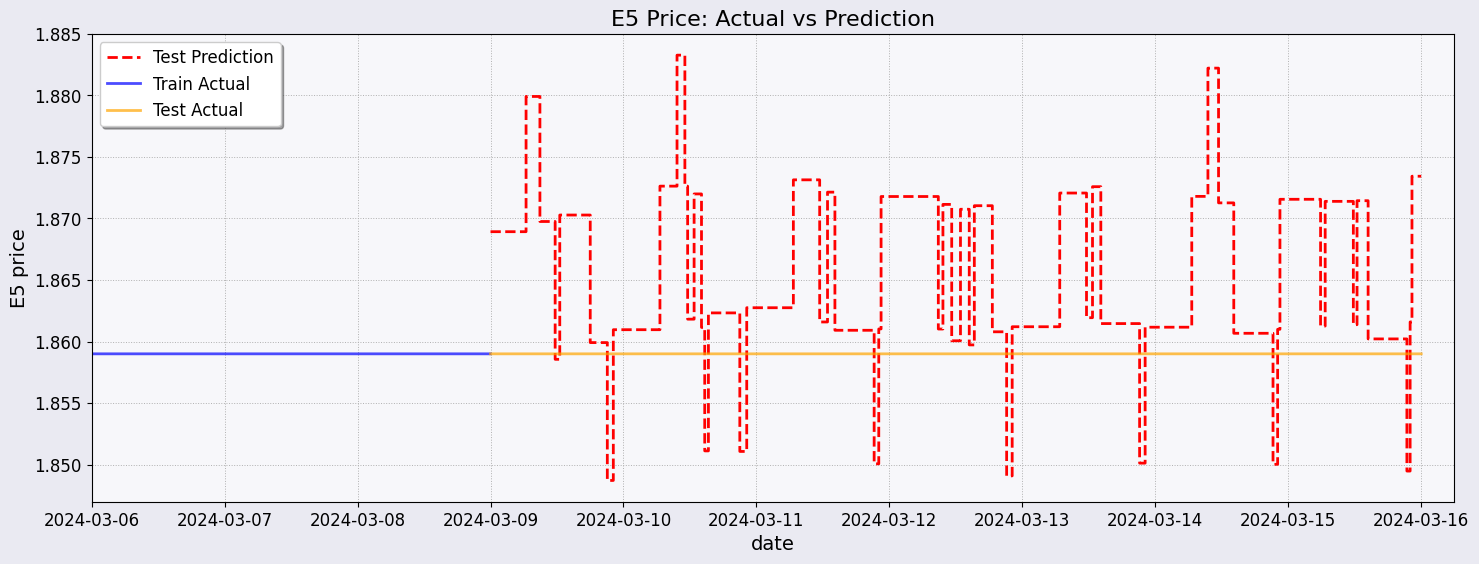

Successfully processed df29

Processing dataset: df30


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/oghx0zwh.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/1cfebt71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25356', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/oghx0zwh.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/1cfebt71.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmpakeht_wg/prophet_modelwumjkf3c/prophet_model-20250619191528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:15:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.5058
1-Day RMSE in cent: 1.8491
1-Day r2-score: 0.5509
3-Day MAE in cent: 1.6674
3-Day RMSE in cent: 2.0359
3-Day r2-score: 0.5194
7-Day MAE in cent: 2.2778
7-Day RMSE in cent: 2.9075
7-Day r2-score: 0.3005


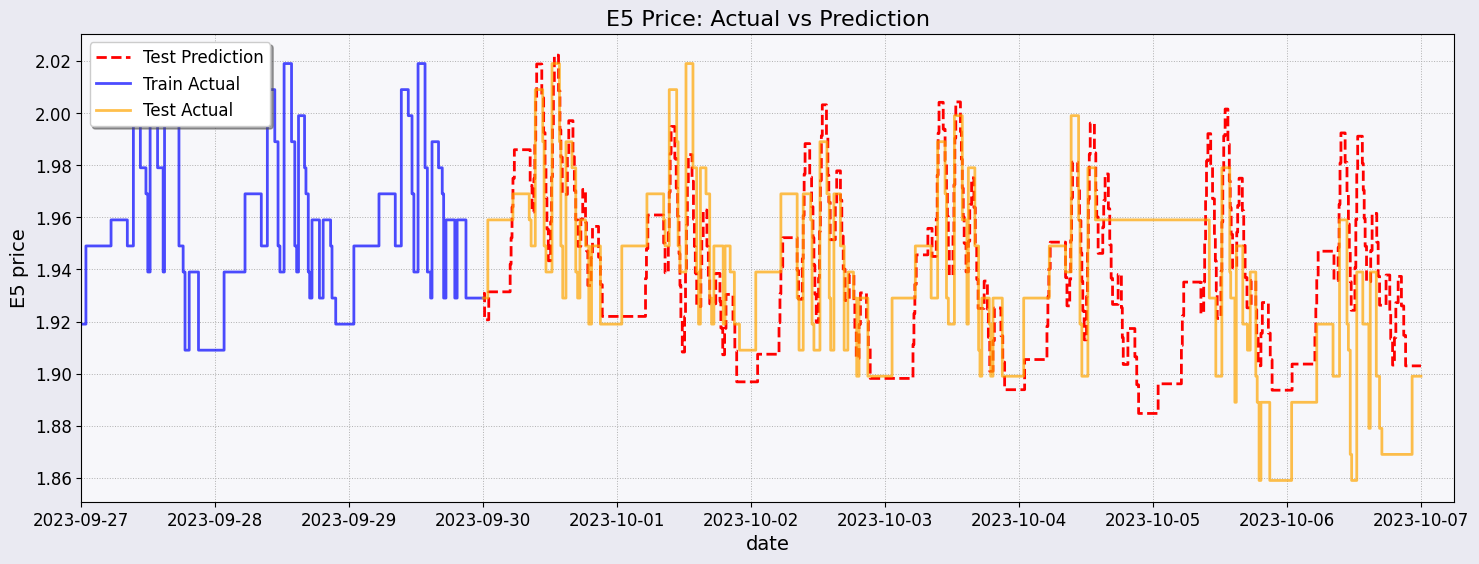

Successfully processed df30

=== Error Summary ===
All datasets processed successfully!


In [6]:
forecast_freq = 5 # minutes, discretization between individual values of the forecast
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter

# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()

        with mlflow.start_run(run_name=f"fuel_model_Anton_{dataset_name}") as run:
            mlflow.set_tag("dataset", f'{dataset_name}')

            train_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = train_days)
            train_end = pd.to_datetime(df_train['date'].iloc[-1])
            # The forecast starts immediately after the training data ends
            forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
            # The forecast extends for 'forecast_days' from its start
            forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)


            # block required to resample the data to the desired frequency
            #speeds up Prophet enormously
            df_prophet = df_train[(df_train['date'] >= train_start) & (df_train['date'] <= train_end) ]
            df_prophet.set_index('date', inplace = True)
            df_prophet.sort_index(inplace = True)
            df_prophet = df_prophet.asfreq(f'{sampling_rate}T')
            df_prophet = df_prophet.asfreq(pd.infer_freq(df_prophet.index)) # the infer_freq function will automatically detect the frequency of the time series data
            df_prophet = df_prophet.reset_index().rename(columns={'date': 'ds', 'e5': 'y'}) # Prophet requires certain column names for prediction
            df_prophet = df_prophet[['ds', 'y']]
    
    
            df_regressor = df_test[['date', 'e5']]
            df_regressor = df_regressor.rename(columns={'date': 'ds', 'e5': 'y'}) # Prophet requires certain column names for prediction
    
            df_regressor = pd.concat([df_prophet[['ds', 'y']],df_regressor]) # just to get also the visible predictions of the train set
    
            #Prophet itself
    
            m = Prophet(
                growth='linear',
    
                changepoint_prior_scale= 0.75,  # The higher the value, the more flexible the trend
                n_changepoints = 100, # Number of changepoints in the changepoint_range by default 80% of the data. In our case should be way higher and somehow connected to the train set length
                changepoint_range = 0.8, # The percentage of the history in which the changepoints are allowed to be placed. Default is 0.8. 
                #Since in our case the recent data is very important, try to extend to 0.9 or even 1. However for higher values fit sometimes goes nowhere
    
    
                seasonality_mode='additive', # in our case multiplicative should not be the better choice
                daily_seasonality=False,
                weekly_seasonality=False,
                yearly_seasonality=False
            )
            m.add_seasonality(name='daily', period=1, fourier_order=17, prior_scale = 30) # fourier 17 30
            m.add_seasonality(name='weekly', period= 7, fourier_order=20, prior_scale = 30) # fourier  20 40
    
            m.fit(df_prophet)

            # Forecasting

            forecast = m.predict(df_regressor)
            forecast = step_modification_to_forecast(forecast, threshold = 0.01) # makes the prediction less nervous:)
    
            mlflow.prophet.log_model(m)
    
            # Plot
    
            train_plot_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = 2)
            train_plot_end = pd.to_datetime(df_train['date'].iloc[-1]) + pd.Timedelta(days = 1)
    
            train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
            test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), pd.to_datetime(forecast_end_date.strftime('%Y-%m-%d'))+ pd.Timedelta(days = 1.25))
    
            prophet_pred_plot = forecast[['ds', 'yhat']].copy()
            prophet_pred_plot = prophet_pred_plot.rename(columns={'ds': 'date', 'yhat': 'e5'})
            prophet_pred_plot['date'] = pd.to_datetime(prophet_pred_plot['date'])
    
            mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day = plot_forecast(
                 df_train,
                 df_test, 
                 None, 
                 prophet_pred_plot, 
                 prophet_pred_plot, 
                 train_dates_plot, 
                 test_dates_plot, 
                 train_dates_plot, 
                 test_dates_plot 
                 )
            #mlflow.log_artifact("prediction.png")
            mlflow.log_metrics({
            "mae_1_day": mae_1_day,
            "mae_3_day": mae_3_day,
            "mae_7_day": mae_7_day,
            "rmse_1_day": rmse_1_day,
            "rmse_3_day": rmse_3_day,
            "rmse_7_day": rmse_7_day,
            "r2_1_day": r2_1_day,
            "r2_3_day": r2_3_day,
            "r2_7_day": r2_7_day
            })


        print(f"Successfully processed {dataset_name}")

    except Exception as e:
            # Log the error and continue with next dataset
            error_message = f"Error in {dataset_name}: {str(e)}"
            error_log[dataset_name] = error_message
            print(error_message)

            # Make sure to end the MLflow run if it failed
            mlflow.end_run()
            continue


# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")


In [7]:
mlflow.end_run()

In [8]:
#Check data:

%mlflow ui --backend-store-uri file:data/mlflow

UsageError: Line magic function `%mlflow` not found.
